In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df  = pd.read_csv("titanic.csv")
df.head()

In [ ]:
## To check null values
df.info()

The info() function is used to print a concise summary of a DataFrame. This method prints information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.

In [ ]:
df.describe()

The describe() method is used for calculating some statistical data like percentile, mean and std of the numerical values of the Series or DataFrame. It analyzes both numeric and object series and also the DataFrame column sets of mixed data types.

In [ ]:
df['Age']

In [ ]:
df['Embarked'].value_counts()

Pandas value_counts() function returns a Series containing counts of unique values. By default, the resulting Series is in descending order without any NA values. For example, let’s get counts for the column “Embarked” from the Titanic dataset.

In [ ]:
# Age, Fare, Embarked have null values so we are doing mean, median and alphabet imputation
df['Age'] = df.Age.fillna(df.Age.mean())
df['Fare'] = df.Fare.fillna(df.Fare.median())
df['Embarked'] = df['Embarked'].fillna('S') ## as it has high value count
df.info()

In [ ]:
## To check all the unique values in a dataset
df.nunique()

In [ ]:
## As age cannot be in float
df = df.astype({"Age": int})

In [ ]:
df

In [ ]:
# To check particular passenger had a cabin or not?
## here is null gives true wherever it finds nan value but we want true where it doesnot have nan values so we used tilt symbol
df['Cabin_Exist'] = ~df.Cabin.isnull()
## show data
df.head(6)

In [ ]:
## This lamda re.seach will give the title of the names as we choose group1 out of it
df['Title'] = df.Name.apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=df);
plt.xticks(rotation=45);

In [ ]:
## we did this in order to know reduce the categories
df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'})
df['Title'] = df['Title'].replace(['Don', 'Dona', 'Rev', 'Dr',
                                            'Major', 'Lady', 'Sir', 'Col', 'Capt', 'Countess', 'Jonkheer'],'Special')
sns.countplot(x='Title', data=df);
plt.xticks(rotation=45);

In [ ]:
df.head(10)

In [ ]:
# grouping numerical columns
## q stands for quartile range for eg it will try to group data in 4 bins having 0-15%, 15-35%, 35-51%, 51-78% and 78-100%.
## It segregates data based on datapoints like its checks whether the datapoint lies in first 15% of the data, or next(15-35)15% of data
df['Age_Group'] = pd.qcut(df.Age, q=4, labels=False)
df['Fare_range']= pd.qcut(df.Fare, q=4, labels=False)
df.head(11)

In [ ]:
## Now we will do feature selection
## we will remove coloumns that are unrelevant for us
df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket', 'Fare','Age'], axis=1, inplace=True)
df.head(6)

In [ ]:
## Add a feature or column as we can observe Parch meaning parent and sibling meaqns child so we can create a column named Family merging 2 columns in 1
df['Family'] = df.Parch + df.SibSp
df.head(10)

In [ ]:
## again we will drop the column
df =  df.drop(['SibSp','Parch'], axis=1)
df.head()

In [ ]:
df

In [ ]:
## now we will convert categorical data into binary as it helps to get good relationship when training ML model
df_one_hot_encoding = pd.get_dummies(df,drop_first=True)
df_one_hot_encoding.head(6)

In [ ]:
df_one_hot_encoding = df_one_hot_encoding.drop(['Survived'], axis=1)
df_one_hot_encoding.head()

## OUR DATA IS ALL SET TO GET TRAINED !!

# Standarization Vs Normalization

##  Normalization(min-max Normalization)

### Here, we try to  scale down values of feature between 0 to 1
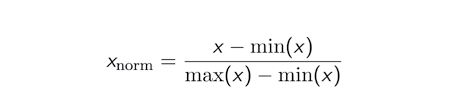

### Importing MinMaxScalar library 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaling = MinMaxScaler()

#### This features is noted down based on various units and magnitude.So there is a huge difference between these features..its scaled down to 0 to 1. So all features are on same scale.

In [ ]:
df_one_hot_encoding.head(3)

In [ ]:
new_list = list(df_one_hot_encoding.columns)
new_list

In [ ]:
scaled = scaling.fit_transform(df_one_hot_encoding)
scaled = pd.DataFrame(scaled, columns=new_list)

In [ ]:
print("Scaled Dataset Using MinMaxScaler")
scaled.head()

# Standarization(Standard Scalar)

### All features are transformed in such a way that it will have properties of standard normal distribution where mean = 0 and standard deviation =1
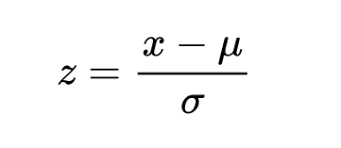

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
st_sc = scale.fit_transform(df_one_hot_encoding)
st_sc = pd.DataFrame(st_sc, columns=new_list)
print("Scaled Dataset Using StandardScaler")
st_sc.head(6)

## When to use Standarization or Normalization ??

#### Scenario : Machine Learning algorithms that involves Euclidean Distance and Some Depp learning techiniques where gradient descent is involved where you need to find best minimal  point. To get to that point we have algorithms like K-means, KNN, Linear Regression, Logistic Regression all deep learning networks
#### Standarization mostly performs well than Normalization.

#### You don't need to perform Scaling when you go for decision Tree, Random Forest, XGBoost or all boosting technics.

### Now, we will convert the pandas dataframe into spark dataframe

In [ ]:
import findspark
findspark.find()
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

In [ ]:
spark = SparkSession.builder.appName("Feature-Engineering with Spark").getOrCreate()

### Create PySpark DataFrame from Pandas

In [ ]:
sparkDF=spark.createDataFrame(st_sc) 
sparkDF.printSchema()
sparkDF.show(10)

In [ ]:
cols = sparkDF.columns
assembler = VectorAssembler(inputCols=cols,outputCol="list_of_features")
data = assembler.transform(sparkDF)
data.select("list_of_features").show(10,truncate=False)

In [ ]:
spark.stop()